In [ ]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import os
import joblib
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [ ]:
# Cell 2: Advanced Data Loading and Cleaning 
def clean_text(text):
    
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_and_preprocess_data(paths):
   
    all_data = []
    for path in paths:
        try:
            df_temp = None
            filename = os.path.basename(path)

            if filename == 'phishing_email.csv':
                df_temp = pd.read_csv(path, encoding='latin1', on_bad_lines='skip')
                df_temp = df_temp.rename(columns={'text_combined': 'Message', 'label': 'Category'})
                df_temp['Label'] = df_temp['Category'].map({
                    0: 'Legitimate',
                    1: 'Phishing'
                })
                df_temp['Type'] = 'Email'

            elif filename in ['SMSSpamCollection', 'Spam_SMS.csv', 'sms.csv']:
                if 'SMSSpamCollection' in filename:
                    df_temp = pd.read_csv(path, sep='\t', header=None, names=["Category", "Message"])
                else:
                    df_temp = pd.read_csv(path, encoding='latin1')
                    df_temp.columns = ["Category", "Message"][:len(df_temp.columns)]
                df_temp['Label'] = df_temp['Category'].map({'ham': 'Legitimate', 'spam': 'Spam'})
                df_temp['Type'] = 'SMS'
            else: # Handles all other email files
                df_temp = pd.read_csv(path, encoding='latin1', on_bad_lines='skip')
                if 'body' in df_temp.columns and 'subject' in df_temp.columns:
                    df_temp['Message'] = df_temp['subject'].fillna('') + ' ' + df_temp['body'].fillna('')
                elif 'Message' in df_temp.columns:
                    pass
                else: # Fallback
                    df_temp['Message'] = df_temp.iloc[:, 1].astype(str)
                if any(k in filename for k in ['CEAS', 'Nazario', 'Nigerian_Fraud']):
                    df_temp['Label'] = 'Phishing'
                elif any(k in filename for k in ['Enron', 'Ling', 'SpamAssasin']):
                    df_temp['Label'] = df_temp['label'].map({0: 'Legitimate', 1: 'Spam'})
                df_temp['Type'] = 'Email'

            if df_temp is not None:
                all_data.append(df_temp[['Message', 'Label', 'Type']])

        except FileNotFoundError:
            print(f"Warning: Skipping file {path}. Not found.")
        except Exception as e:
            print(f"Warning: Skipping {path} due to error: {e}")

    if not all_data:
        raise ValueError("No data loaded. Please check file paths and formats.")
    df_full = pd.concat(all_data, ignore_index=True).dropna(subset=["Message", "Label"])
    df_full['CleanMessage'] = df_full['Message'].apply(clean_text)
    return df_full

In [ ]:
# Cell 3: Feature Engineering
def extract_meta_features(df):
    """Creates new features based on the message content."""
    df['message_len'] = df['CleanMessage'].apply(len)
    df['word_count'] = df['CleanMessage'].apply(lambda x: len(x.split()))
    df['percent_caps'] = df['Message'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / (len(str(x)) + 1))
    df['url_count'] = df['Message'].astype(str).str.count(r'http[s]?://|www\.')
    return df

In [ ]:

# Cell 4: Main Data Preparation 
paths = [
     "datasets/CEAS_08.csv", "datasets/Enron.csv", "datasets/Ling.csv", "datasets/Nazario.csv", "datasets/Nigerian_Fraud.csv",
    "datasets/sms.csv", "datasets/SMSSpamCollection", "datasets/Spam_SMS.csv", "datasets/SpamAssasin.csv", "datasets/phishing_email.csv"
]
df_full = load_and_preprocess_data(paths)
df_full = extract_meta_features(df_full)
df_sms = df_full[df_full['Type'] == 'SMS'].copy()
df_email = df_full[df_full['Type'] == 'Email'].copy()
sms_class_map = {0: 'Legitimate', 1: 'Spam'}
email_class_map = {0: 'Legitimate', 1: 'Spam', 2: 'Phishing'}
df_sms['LabelNum'] = df_sms['Label'].map({v: k for k, v in sms_class_map.items()})
df_email['LabelNum'] = df_email['Label'].map({v: k for k, v in email_class_map.items()})
df_full['TypeNum'] = df_full['Type'].map({'SMS': 0, 'Email': 1})
df_sms.dropna(subset=['LabelNum', 'CleanMessage'], inplace=True)
df_email.dropna(subset=['LabelNum', 'CleanMessage'], inplace=True)
df_full.dropna(subset=['TypeNum', 'CleanMessage'], inplace=True)
print("Data Loading, Cleaning, and Feature Engineering Complete.")
print(f"Total Samples: {len(df_full)}, SMS Samples: {len(df_sms)}, Email Samples: {len(df_email)}")
print("\nEmail Class Distribution (Original):\n", df_email['Label'].value_counts())
print("\nSMS Class Distribution (Original):\n", df_sms['Label'].value_counts())

Data Loading, Cleaning, and Feature Engineering Complete.
Total Samples: 181690, SMS Samples: 16718, Email Samples: 164972

Email Class Distribution (Original):
 Label
Phishing      86942
Legitimate    61878
Spam          16152
Name: count, dtype: int64

SMS Class Distribution (Original):
 Label
Legitimate    14477
Spam           2241
Name: count, dtype: int64



Plotting Original Class Distributions...


C:\Users\admin\AppData\Local\Temp\ipykernel_14348\1344445279.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_sms, palette='viridis').set_title('Original SMS Class Distribution')
C:\Users\admin\AppData\Local\Temp\ipykernel_14348\1344445279.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df_email, palette='plasma', order=['Legitimate', 'Spam', 'Phishing']).set_title('Original Email Class Distribution')


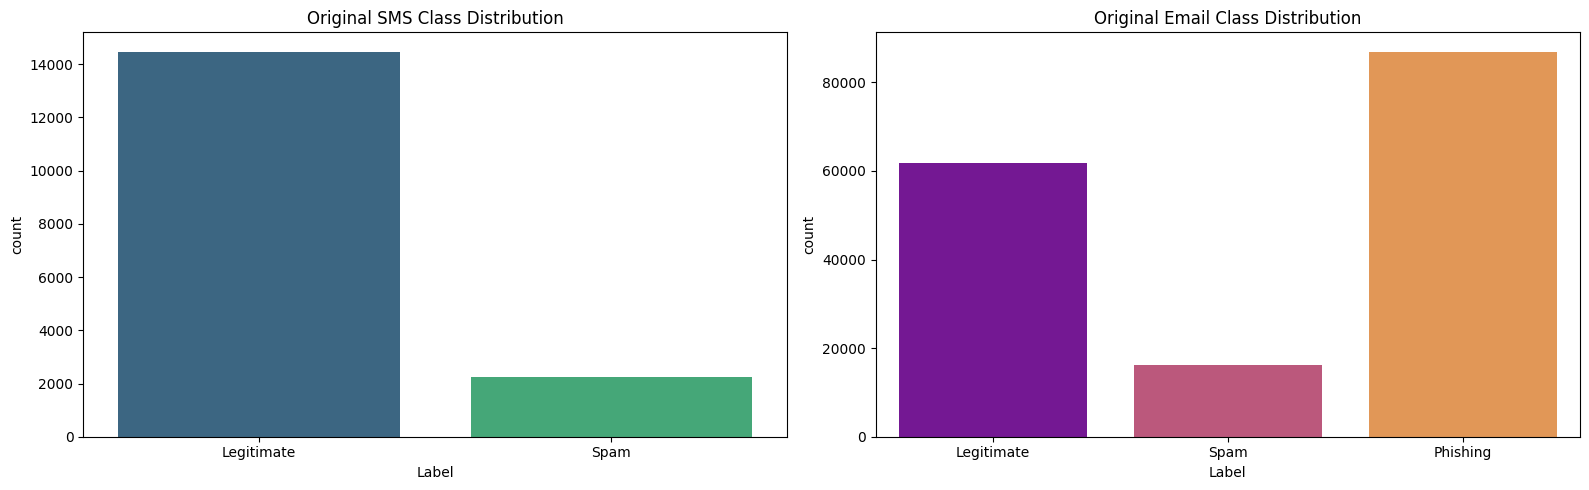

In [ ]:
# Cell 5: Data Visualization (EDA) 
print("\nPlotting Original Class Distributions...")
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='Label', data=df_sms, palette='viridis').set_title('Original SMS Class Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x='Label', data=df_email, palette='plasma', order=['Legitimate', 'Spam', 'Phishing']).set_title('Original Email Class Distribution')
plt.tight_layout()
plt.show()

In [ ]:
#  Cell 6: Visualize Class Balance After Applying SMOTE 
def visualize_smote_effect(X_sms_train, y_sms_train, X_email_train, y_email_train, preprocessor):
    
    print("\nVisualizing Class Balance After Applying SMOTE for Training Data...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    smote = SMOTE(random_state=42)
    # SMS Plot
    X_sms_train_transformed = preprocessor.fit_transform(X_sms_train)
    _, y_sms_resampled = smote.fit_resample(X_sms_train_transformed, y_sms_train)
    sns.countplot(x=y_sms_resampled, ax=axes[0], palette='viridis')
    axes[0].set_title('SMS Class Distribution After SMOTE')
    axes[0].set_xticklabels(['Legitimate', 'Spam'])
    axes[0].set_xlabel("Class")
    # Email Plot 
    X_email_train_transformed = preprocessor.transform(X_email_train)
    _, y_email_resampled = smote.fit_resample(X_email_train_transformed, y_email_train)
    sns.countplot(x=y_email_resampled, ax=axes[1], palette='plasma')
    axes[1].set_title('Email Class Distribution After SMOTE')
    axes[1].set_xticklabels(['Legitimate', 'Spam', 'Phishing'])
    axes[1].set_xlabel("Class")
    plt.tight_layout()
    plt.show()

In [ ]:
#  Cell 7: Build Professional Preprocessing Pipeline 
numeric_features = ['message_len', 'word_count', 'percent_caps', 'url_count']
text_feature = 'CleanMessage'
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000), text_feature),
        ('scaler', StandardScaler(), numeric_features)
    ],
    remainder='drop')


In [ ]:
#  Cell 8: Model Training Functions 
def train_or_load_model(model_path, X_train, y_train, X_test, y_test, pipeline_steps, class_map):
    if not os.path.exists(model_path):
        model_name = model_path.replace('.joblib', '').replace('_', ' ').title()
        print(f"\n--- Training New {model_name} ---")
        model = ImbPipeline(pipeline_steps)
        model.fit(X_train, y_train)
        print(f"\n--- Evaluation Report for {model_name} on Test Data ---")
        y_pred = model.predict(X_test)
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred, target_names=class_map.values(), zero_division=0))
        joblib.dump(model, model_path)
    else:
        print(f"\n--- Loading Existing {model_path} ---")
        model = joblib.load(model_path)
    return model


--- Initializing Models ---

Visualizing Class Balance After Applying SMOTE for Training Data...


C:\Users\admin\AppData\Local\Temp\ipykernel_14348\2403746500.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_sms_resampled, ax=axes[0], palette='viridis')
C:\Users\admin\AppData\Local\Temp\ipykernel_14348\2403746500.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Legitimate', 'Spam'])
C:\Users\admin\AppData\Local\Temp\ipykernel_14348\2403746500.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_email_resampled, ax=axes[1], palette='plasma')
C:\Users\admin\AppData\Local\Temp\ipykernel_14348\2403746500.py:19: UserWarning: set_ticklabels() should only be used w

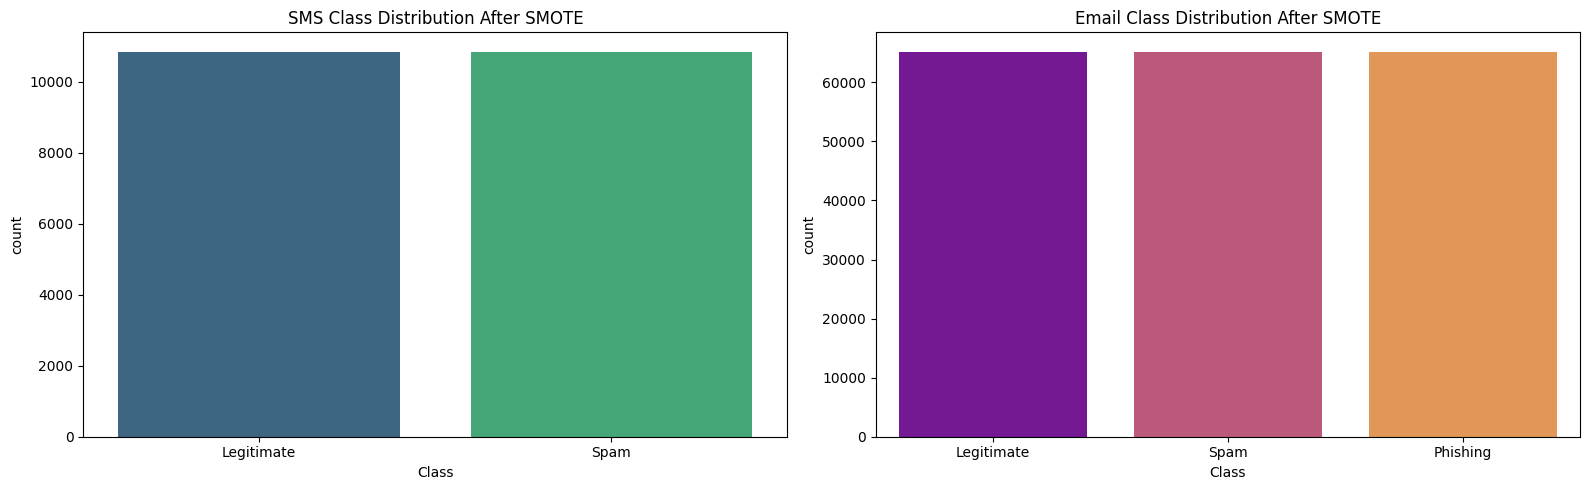


--- Loading Existing router_model.joblib ---

--- Loading Existing sms_model.joblib ---

--- Loading Existing email_model.joblib ---

--- All models are ready. ---


In [ ]:
# Cell 9: Initialize Models 
print("\n--- Initializing Models ---")
X_sms_train, X_sms_test, y_sms_train, y_sms_test = train_test_split(df_sms, df_sms['LabelNum'], test_size=0.25, random_state=42, stratify=df_sms['LabelNum'])
X_email_train, X_email_test, y_email_train, y_email_test = train_test_split(df_email, df_email['LabelNum'], test_size=0.25, random_state=42, stratify=df_email['LabelNum'])
visualize_smote_effect(X_sms_train, y_sms_train, X_email_train, y_email_train, preprocessor) # Optional: uncomment to see SMOTE plot on first run
router_pipeline_steps = [
    ('tfidf', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('clf', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
]
if not os.path.exists('router_model.joblib'):
    print("\n--- Training New Router Model ---")
    X_router_train, X_router_test, y_router_train, y_router_test = train_test_split(df_full['CleanMessage'], df_full['TypeNum'], test_size=0.25, random_state=42, stratify=df_full['TypeNum'])
    router_model = Pipeline(router_pipeline_steps)
    router_model.fit(X_router_train, y_router_train)
    print(f"Router Model Accuracy: {router_model.score(X_router_test, y_router_test):.4f}")
    joblib.dump(router_model, 'router_model.joblib')
else:
    print("\n--- Loading Existing router_model.joblib ---")
    router_model = joblib.load('router_model.joblib')
sms_pipeline_steps = [('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', LinearSVC(random_state=42, class_weight='balanced', dual=False, max_iter=2000))]
sms_model = train_or_load_model('sms_model.joblib', X_sms_train, y_sms_train, X_sms_test, y_sms_test, sms_pipeline_steps, sms_class_map)
email_pipeline_steps = [('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', LinearSVC(random_state=42, class_weight='balanced', dual=False, max_iter=2000))]
email_model = train_or_load_model('email_model.joblib', X_email_train, y_email_train, X_email_test, y_email_test, email_pipeline_steps, email_class_map)
print("\n--- All models are ready. ---")

In [ ]:
# Cell 10: Automatic Prediction Function 
def get_automatic_prediction(router, sms_clf, email_clf):
    message_content = input("\nPlease paste the full message (SMS or Email) to check:\n")
    timestamp = datetime.now()
    input_df = pd.DataFrame({'Message': [message_content]})
    input_df['CleanMessage'] = input_df['Message'].apply(clean_text)
    input_df = extract_meta_features(input_df)
    predicted_type_num = router.predict(input_df['CleanMessage'])[0]
    if predicted_type_num == 0:
        message_type = 'SMS'
        final_prediction_num = sms_clf.predict(input_df)[0]
        final_prediction_label = sms_class_map[final_prediction_num]
    else:
        message_type = 'Email'
        final_prediction_num = email_clf.predict(input_df)[0]
        final_prediction_label = email_class_map[final_prediction_num]
    
    print("\n" + "="*20 + " ANALYSIS RESULT " + "="*20)
    print(f"Message Type Identified : {message_type}")
    print(f"Final Prediction        : {final_prediction_label}")
    print(f"Original Message        : {message_content[:150] + '...' if len(message_content) > 150 else message_content}")
    print("="*57 + "\n")
    
    user_summary = input("Enter a one-line summary for this message (optional): ").strip()
    
    return {
        'timestamp': timestamp,
        'type': message_type,
        'classification': final_prediction_label,
        'content': message_content,
        'summary': user_summary or "N/A"
    }

In [ ]:
# Cell 11: Excel Logging Function 
def save_log_to_excel(log_data):
    if not log_data:
        print("No new predictions to log.")
        return
    
    log_df = pd.DataFrame(log_data)
    log_df['date'] = log_df['timestamp'].dt.date
    log_df['time'] = log_df['timestamp'].dt.strftime('%H:%M:%S')

    for i, row in log_df.iterrows():
        content = row.get('content', '')
        words = content.split()
        log_df.at[i, 'preview'] = ' '.join(words[:30]) + '...' if len(words) > 30 else content
        
    new_log_df = log_df[['date', 'time', 'summary', 'classification', 'type', 'preview']]
    log_filename = 'prediction_log.xlsx'
    
    try:
        if os.path.exists(log_filename):
            existing_df = pd.read_excel(log_filename, index_col='sl no')
            combined_df = pd.concat([existing_df, new_log_df], ignore_index=True)
        else:
            combined_df = new_log_df
            
        combined_df.index = np.arange(1, len(combined_df) + 1)
        combined_df.index.name = 'sl no'
        combined_df.to_excel(log_filename)
        print(f"\nSession log saved successfully to '{log_filename}'.")
    except Exception as e:
        print(f"\nError saving to Excel: {e}")

In [ ]:
# Cell 12: Main Application Loop 
def run_classifier_app(router, sms_clf, email_clf):
    session_logs = []
    

    print("\n--- Starting SMS and Email Fraud Detection Tool (V3.5) ---")
    
    while True:
        result = get_automatic_prediction(router, sms_clf, email_clf)
        session_logs.append(result) # All results are still saved for the Excel log
        
        if input("\nCheck another message? (yes/no): ").lower().strip() != 'yes':
            break
            
    save_log_to_excel(session_logs)

In [ ]:
# Cell 13: Run the Application 
if __name__ == "__main__":
    run_classifier_app(router_model, sms_model, email_model)
    print("\n--- Application Finished ---")


--- Starting SMS and Email Fraud Detection Tool (V3.5) ---

==================== ANALYSIS RESULT ====================
Message Type Identified : Email
Final Prediction        : Spam
Original Message        : From: Amazon.in <order-update@amazon.in> Subject: Your Amazon.in order for "Sony WH-1000XM5 Headphones" has been placed!  Body: Hello Priya,  Thank yo...


==================== ANALYSIS RESULT ====================
Message Type Identified : Email
Final Prediction        : Legitimate
Original Message        : From: Rahul Verma <rahul.v@mycompany.com> Subject: Follow-up on the Q4 Marketing Budget  Body: Hi Team,  Following up on our meeting this morning, I'v...


==================== ANALYSIS RESULT ====================
Message Type Identified : Email
Final Prediction        : Spam
Original Message        : From: Miracle Supplements <deals@health-plus-store.net> Subject: 💥 LAST DAY to get 80% OFF on our #1 Weight Loss Formula! 💥  Body: Don't miss out! Tho...


==================== ANA